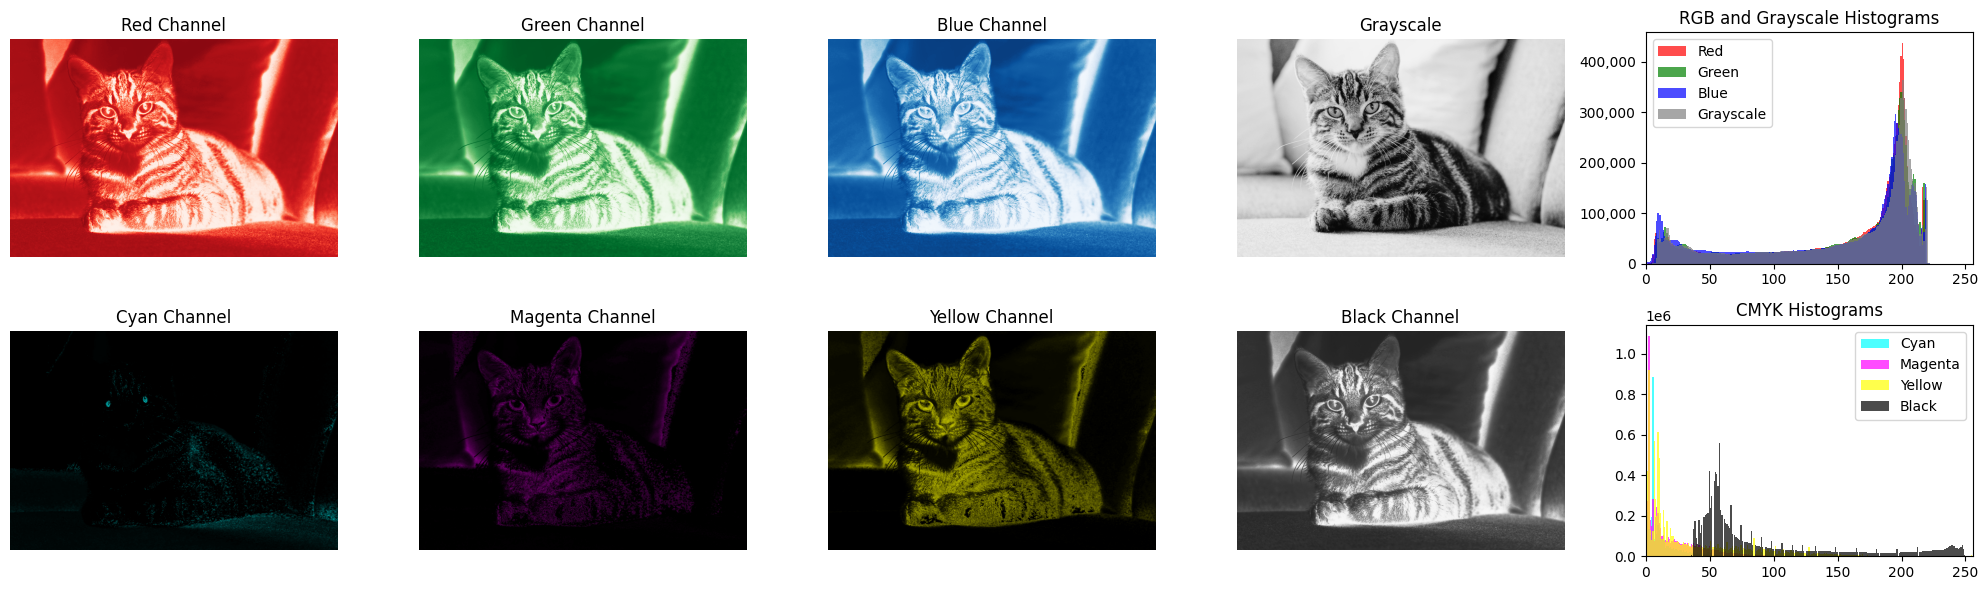

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def rgb_to_cmyk(image):
    image = image / 255.0
    R, G, B = cv2.split(image)
    K = 1 - np.max(image, axis=2)
    K[K == 1] = 0.99  # Avoid division by zero
    C = (1 - R - K) / (1 - K + 1e-8)
    M = (1 - G - K) / (1 - K + 1e-8)
    Y = (1 - B - K) / (1 - K + 1e-8)
    CMYK = cv2.merge((C, M, Y, K))
    return CMYK

def apply_black_background(channel, color):
    h, w = channel.shape
    background = np.zeros((h, w, 3), dtype=np.uint8)
    if color == 'cyan':
        background[:, :, 1] = channel
        background[:, :, 2] = channel
    elif color == 'magenta':
        background[:, :, 0] = channel
        background[:, :, 2] = channel
    elif color == 'yellow':
        background[:, :, 0] = channel
        background[:, :, 1] = channel
    elif color == 'black':
        background[:, :, 0] = channel
        background[:, :, 1] = channel
        background[:, :, 2] = channel
    return background

# Load the image
image = cv2.imread('example.jpg')
if image is None:
    raise FileNotFoundError("The file 'example.jpg' was not found!")

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split RGB channels
R, G, B = cv2.split(image_rgb)

# Convert to Grayscale
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Convert to CMYK
cmyk_image = rgb_to_cmyk(image_rgb)
C, M, Y, K = cv2.split(cmyk_image)

# Scale CMYK channels to 8-bit
C = (C * 255).astype(np.uint8)
M = (M * 255).astype(np.uint8)
Y = (Y * 255).astype(np.uint8)
K = (K * 255).astype(np.uint8)

# Apply black backgrounds
cyan_background = apply_black_background(C, 'cyan')
magenta_background = apply_black_background(M, 'magenta')
yellow_background = apply_black_background(Y, 'yellow')
black_background = apply_black_background(K, 'black')

# Remove zeros from the CMYK channels for histograms
C_non_zero = C[C != 0]
M_non_zero = M[M != 0]
Y_non_zero = Y[Y != 0]
K_non_zero = K[K != 0]

# Plot settings
cols, rows = 5, 2  # Define the grid dimensions
chart_idx = 0  # Initialize the chart index

# Set width of histogram bars
bin_width = 1  # Width of each bar in the histogram (set to 1)
bin_range = 256  # Number of bins

# Plot settings
plt.figure(figsize=(4*cols, 3*rows))  # Dynamically set figure size

# Row 1: RGB channels, and RGB histograms
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(R, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(G, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(B, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

# RGB Histograms in one chart with shifted x-values to avoid overlap
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
# Calculate histograms
r_hist, r_bins = np.histogram(R.ravel(), bins=bin_range, range=(0, 256))
g_hist, g_bins = np.histogram(G.ravel(), bins=bin_range, range=(0, 256))
b_hist, b_bins = np.histogram(B.ravel(), bins=bin_range, range=(0, 256))
gray_hist, gray_bins = np.histogram(gray.ravel(), bins=bin_range, range=(0, 256))
# Plotting the histograms with some offset to avoid overlap
plt.bar(r_bins[:-1] - bin_width * 1.5, r_hist, width=bin_width, color='r', alpha=0.7, label='Red')
plt.bar(g_bins[:-1] - bin_width * 0.5, g_hist, width=bin_width, color='g', alpha=0.7, label='Green')
plt.bar(b_bins[:-1] + bin_width * 0.5, b_hist, width=bin_width, color='b', alpha=0.7, label='Blue')
plt.bar(gray_bins[:-1] + bin_width * 1.5, gray_hist, width=bin_width, color='gray', alpha=0.7, label='Grayscale')
plt.title('RGB and Grayscale Histograms')
plt.xlim([0, 256])
# y축 tick 형식 변경
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{int(value):,}'))
plt.legend()

# Row 2: CMYK channels
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(cyan_background)
plt.title('Cyan Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(magenta_background)
plt.title('Magenta Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(yellow_background)
plt.title('Yellow Channel')
plt.axis('off')

plt.subplot(rows, cols, chart_idx := chart_idx + 1)
plt.imshow(black_background)
plt.title('Black Channel')
plt.axis('off')

# CMYK Histograms in one chart with shifted x-values to avoid overlap
plt.subplot(rows, cols, chart_idx := chart_idx + 1)
# Calculate histograms
c_hist, c_bins = np.histogram(C_non_zero.ravel(), bins=bin_range, range=(0, 256))
m_hist, m_bins = np.histogram(M_non_zero.ravel(), bins=bin_range, range=(0, 256))
y_hist, y_bins = np.histogram(Y_non_zero.ravel(), bins=bin_range, range=(0, 256))
k_hist, k_bins = np.histogram(K_non_zero.ravel(), bins=bin_range, range=(0, 256))
# Plotting the histograms with some offset to avoid overlap
plt.bar(c_bins[:-1] - bin_width * 1.5, c_hist, width=bin_width, color='cyan', alpha=0.7, label='Cyan')
plt.bar(m_bins[:-1] - bin_width * 0.5, m_hist, width=bin_width, color='magenta', alpha=0.7, label='Magenta')
plt.bar(y_bins[:-1] + bin_width * 0.5, y_hist, width=bin_width, color='yellow', alpha=0.7, label='Yellow')
plt.bar(k_bins[:-1] + bin_width * 1.5, k_hist, width=bin_width, color='black', alpha=0.7, label='Black')
plt.title('CMYK Histograms')
plt.xlim([0, 256])
plt.legend()

plt.tight_layout()
plt.show()